In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from scipy import stats
import seaborn as sns

def plot_distr(X, features):
    no_of_features = X.shape[1]
    plt.figure(figsize = (3 * no_of_features,6)) # dpi = 200
    for i in range(no_of_features):
        plt.subplot(2,no_of_features,i + 1)
        sns.distplot(X[:,i], fit = stats.norm)
        (mu, sigma) = stats.norm.fit(X[:,i])
        f_skew = stats.skew(X[:,i])
        f_kurt = stats.kurtosis(X[:,i])
        plt.title('{:s}: \n $\mu$= {:.2f} $\sigma$ = {:.2f} \n skew={:.2f} kurt={:.2f}'.format(features[i] ,mu, sigma, f_skew, f_kurt))
        if i > 0:
            plt.ylabel('')
    for i in range(no_of_features):
        plt.subplot(2,no_of_features,i + X.shape[1] + 1)
        res = stats.probplot(X[:,i], plot=plt)
        plt.title('')
        if i > 0:
            plt.ylabel('')

In [ ]:
df_customer_number = pd.read_csv('count_of_clusters.csv')
df_customer_number.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_customer_number['period'] = [i for i in range(38,91)]
df_customer_number.set_index('period', inplace = True)
df_customer_number.shape

In [7]:
df_flows = pd.read_csv('flow_все.csv')
df_flows.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_flows.shape

(52, 21)

In [8]:
df_flows.head()

,sleeping_to_sleeping,sleeping_to_loyal,sleeping_to_champions,sleeping_to_churn,loyal_to_sleeping,loyal_to_loyal,loyal_to_champions,loyal_to_churn,champions_to_sleeping,champions_to_loyal,...,champions_to_churn,churn_to_sleeping,churn_to_loyal,churn_to_champions,churn_to_churn,count_promo_All,count_promo_Billboards,count_promo_Facades,count_promo_Seasonal,count_promo_Biweekly
0,39.5,5.0,5.0,50.5,40.3,6.2,19.5,34.0,26.0,18.8,...,51.6,15.0,2.3,0.7,82.0,127,7,33,87,0
1,32.9,7.7,3.6,55.7,27.0,5.9,17.1,50.0,28.2,47.4,...,19.1,11.3,1.0,1.5,86.2,236,10,94,87,45
2,33.2,5.8,4.6,56.3,32.8,38.4,3.7,25.0,23.4,6.5,...,49.4,11.3,1.0,1.9,85.9,456,14,83,314,45
3,32.5,6.0,4.1,57.5,33.1,38.2,5.4,23.3,24.4,4.9,...,53.8,11.3,0.9,1.6,86.1,445,46,45,232,122
4,33.4,6.4,4.1,56.1,33.0,39.9,5.0,22.1,26.9,6.0,...,48.8,11.5,0.9,1.8,85.8,497,38,30,352,77


In [9]:
df_flows['period'] = [i for i in range(39,91)]
df_flows.set_index('period', inplace = True)
df_flows.shape

(52, 21)

In [ ]:
clusters = ['sleeping', 'loyal', 'champions', 'churn']
promos = ['count_promo_Billboards','count_promo_Facades', 'count_promo_Seasonal', 'count_promo_Biweekly']
from_sleeping =  ['sleeping_to_sleeping','sleeping_to_loyal','sleeping_to_champions','sleeping_to_churn']
from_loyal    =  ['loyal_to_sleeping', 'loyal_to_loyal','loyal_to_champions', 'loyal_to_churn']
from_champions = ['champions_to_sleeping','champions_to_loyal', 'champions_to_champions', 'champions_to_churn']
from_churn =     ['churn_to_sleeping', 'churn_to_loyal', 'churn_to_champions', 'churn_to_churn']
flows = from_sleeping + from_loyal + from_champions + from_churn

# небольшая проверка, сумма должна быть 100%
print(df_flows[from_sleeping].sum(axis = 1).sum(axis = 0) / df_flows.shape[0])
print(df_flows[from_loyal].sum(axis = 1).sum(axis = 0) / df_flows.shape[0])
print(df_flows[from_champions].sum(axis = 1).sum(axis = 0) / df_flows.shape[0])
print(df_flows[from_churn].sum(axis = 1).sum(axis = 0) / df_flows.shape[0])

99.99615384615383
100.0
99.99807692307692
99.99038461538461


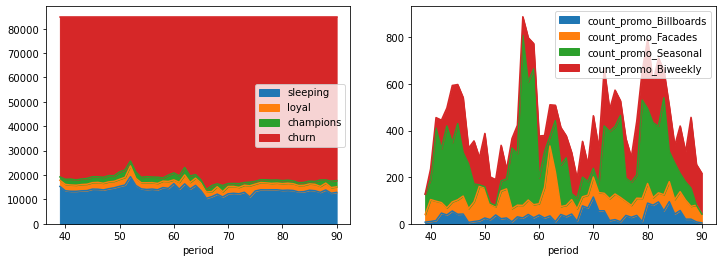

In [ ]:
# Как покупатели распределены по кластерам

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

df_customer_number[clusters][1:].plot.area(ax = ax[0]);
df_flows[promos].plot.area(ax = ax[1]);

#### Singular Sepctrum Analysis

<B>Hypothesis:</B> the rows are very noisy, i.e., in addition to the main factors influencing the flow of buyers between clusters, there are many other small reasons that significantly distort the picture. Therefore, noise must be filtered out. Let's use SSA.


In [ ]:
# This function calculates the SSA decomposition of series into the window_size component

from pyts.decomposition import SingularSpectrumAnalysis
def SSA(flow_set, window_size = 4):
    labels = flow_set.columns
    # Singular Spectrum Analysis
    ssa = SingularSpectrumAnalysis(window_size = window_size, groups = None)
    X = flow_set.values.T
    X_ssa = ssa.fit_transform(X)

    dic = {}
    fig, axes = plt.subplots(nrows = window_size, ncols = 2, figsize=(15, 4 * window_size))
    for i, ax in enumerate(axes):
        ax[0].plot(X[i,:], 'o-', label = labels[i])
        ax[0].plot(X_ssa[i,:].sum(axis = 0), 'o--', label = 'model')
        ax[0].legend(loc='best', fontsize=12)

        for j in range(window_size):
            ax[1].plot(X_ssa[i, j, :], 'o--', label='SSA {0}'.format(j + 1))
            ax[1].legend(loc='best', fontsize=12)

        dic[labels[i]] = X_ssa[i,0,:]
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

    return pd.DataFrame(dic)

**In the left column is the original series and its model** (the sum of the components into which the series is divided using the SSA method). Within the accuracy of the drawing, the curves merge.

**In the right column are the components into which the series is divided**. As we can see, in all cases one component SSA1 (blue line) stands out, the values of which are very different from zero. We can say that it describes a trend. The average values of all other components are close to zero, their variation is insignificant. Thus, for further analysis we select only the first component of all series.

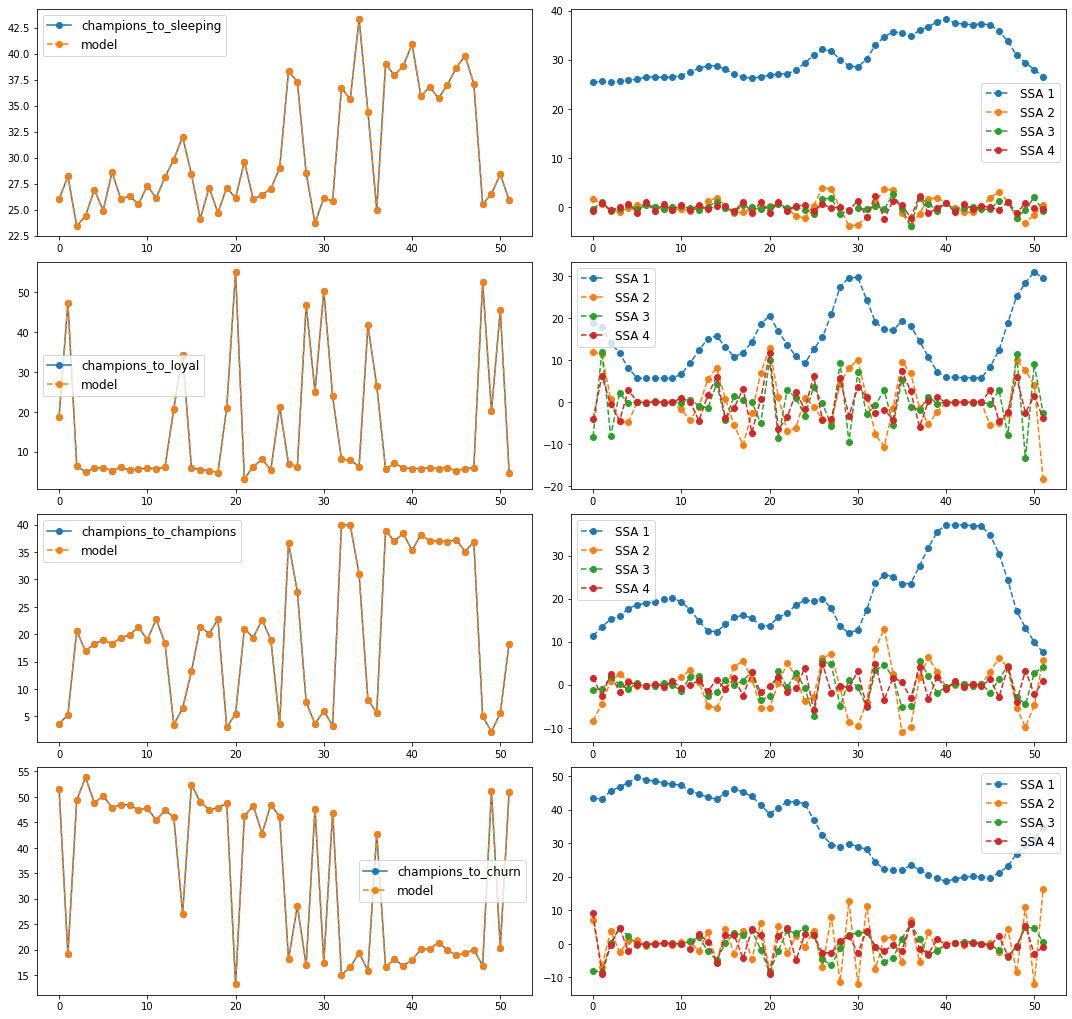

In [ ]:
X_champions = SSA(df_flows[from_champions], window_size = 4)

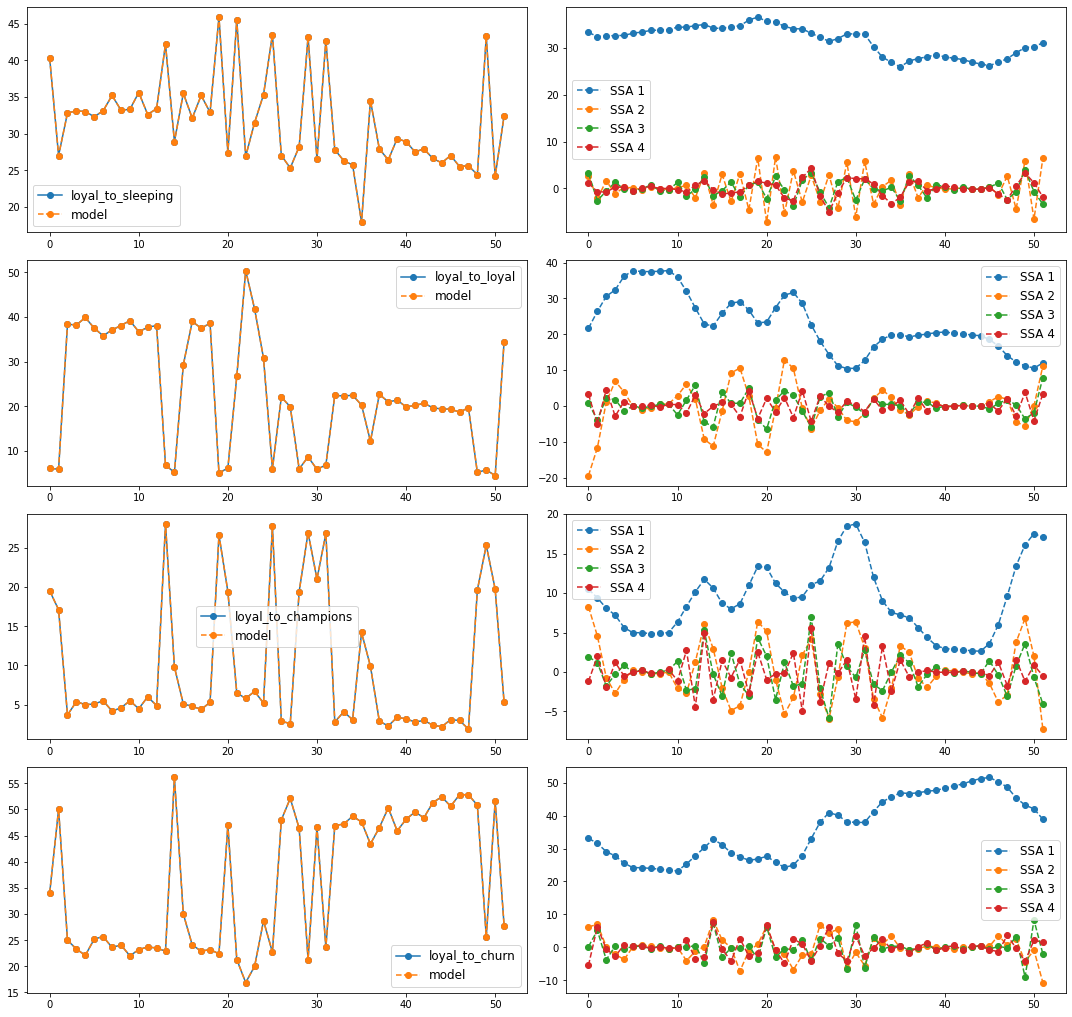

In [ ]:
X_loyal = SSA(df_flows[from_loyal])

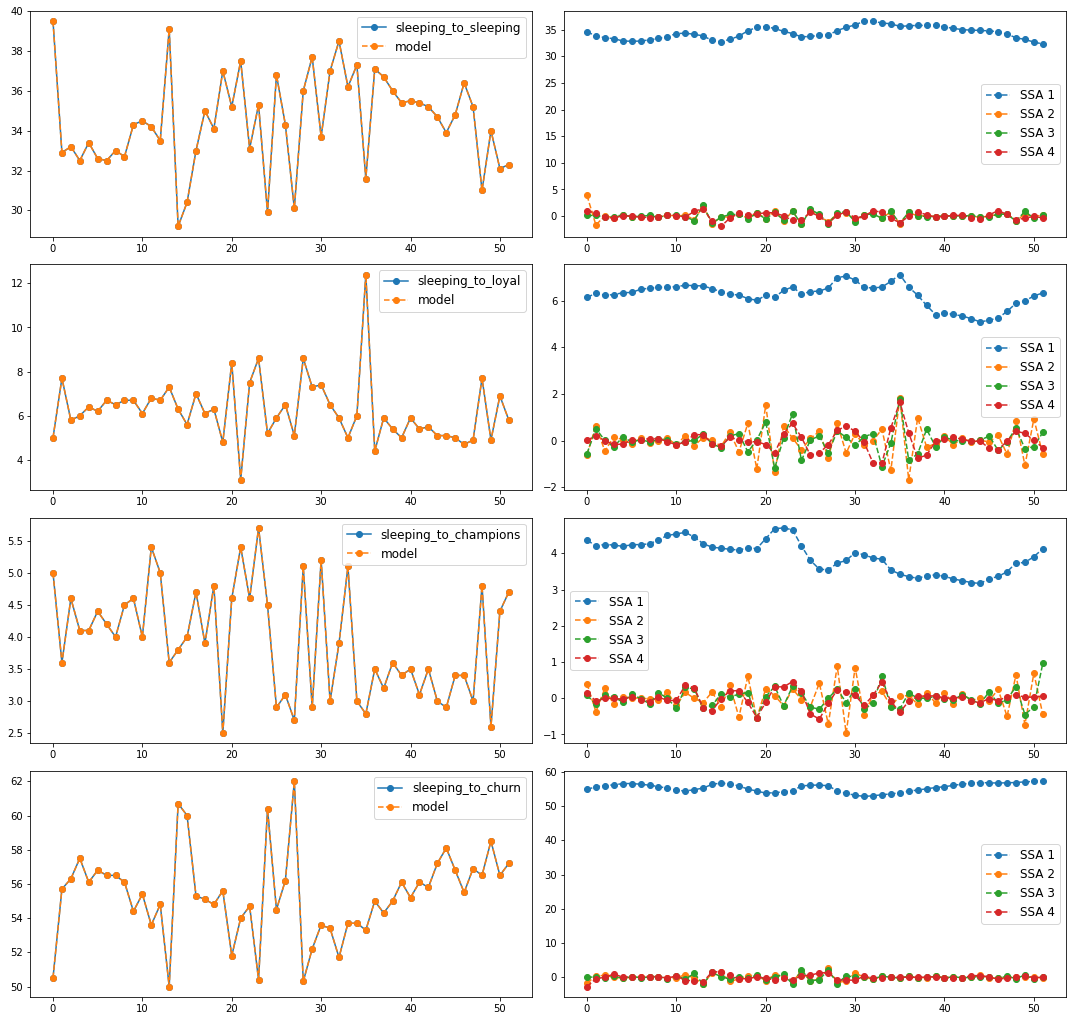

In [ ]:
X_sleeping = SSA(df_flows[from_sleeping])

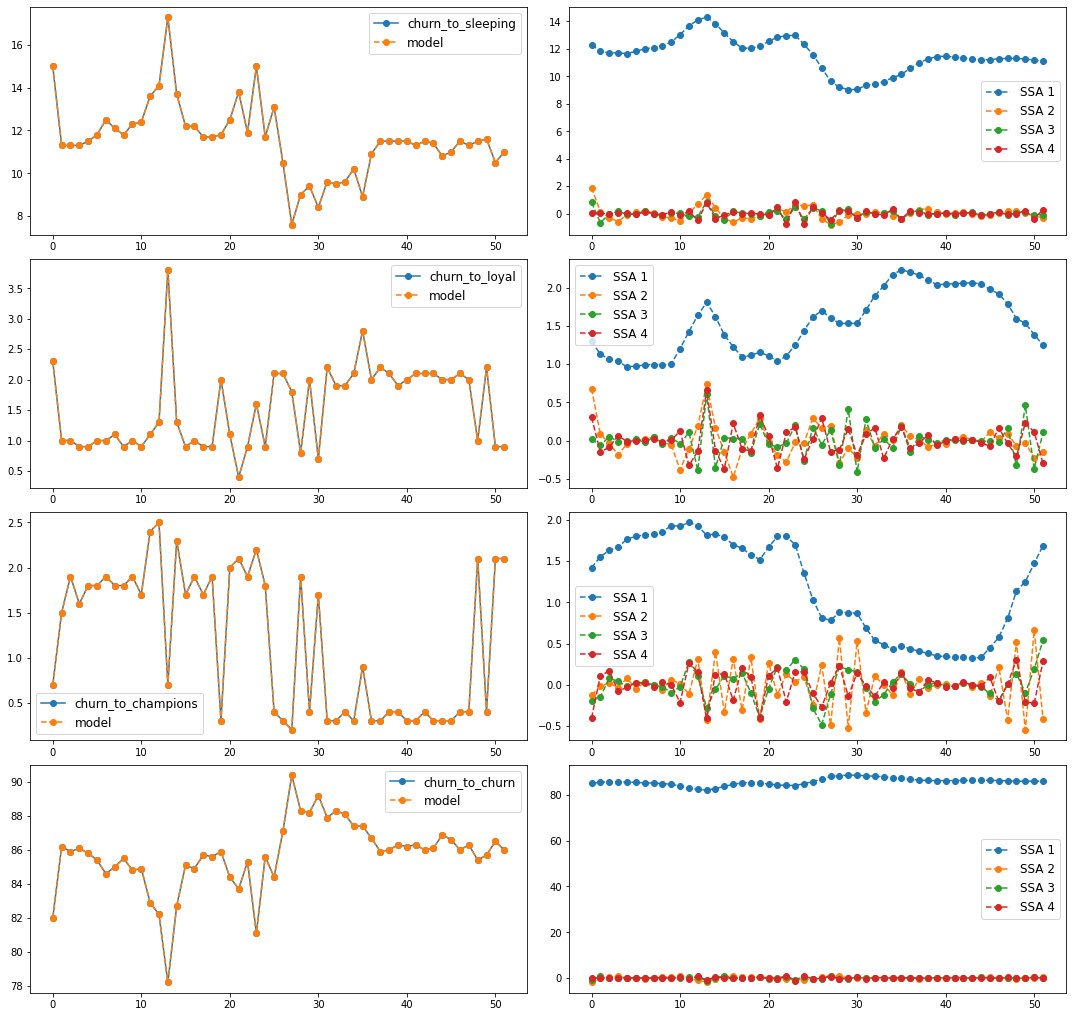

In [ ]:
X_churn = SSA(df_flows[from_churn])

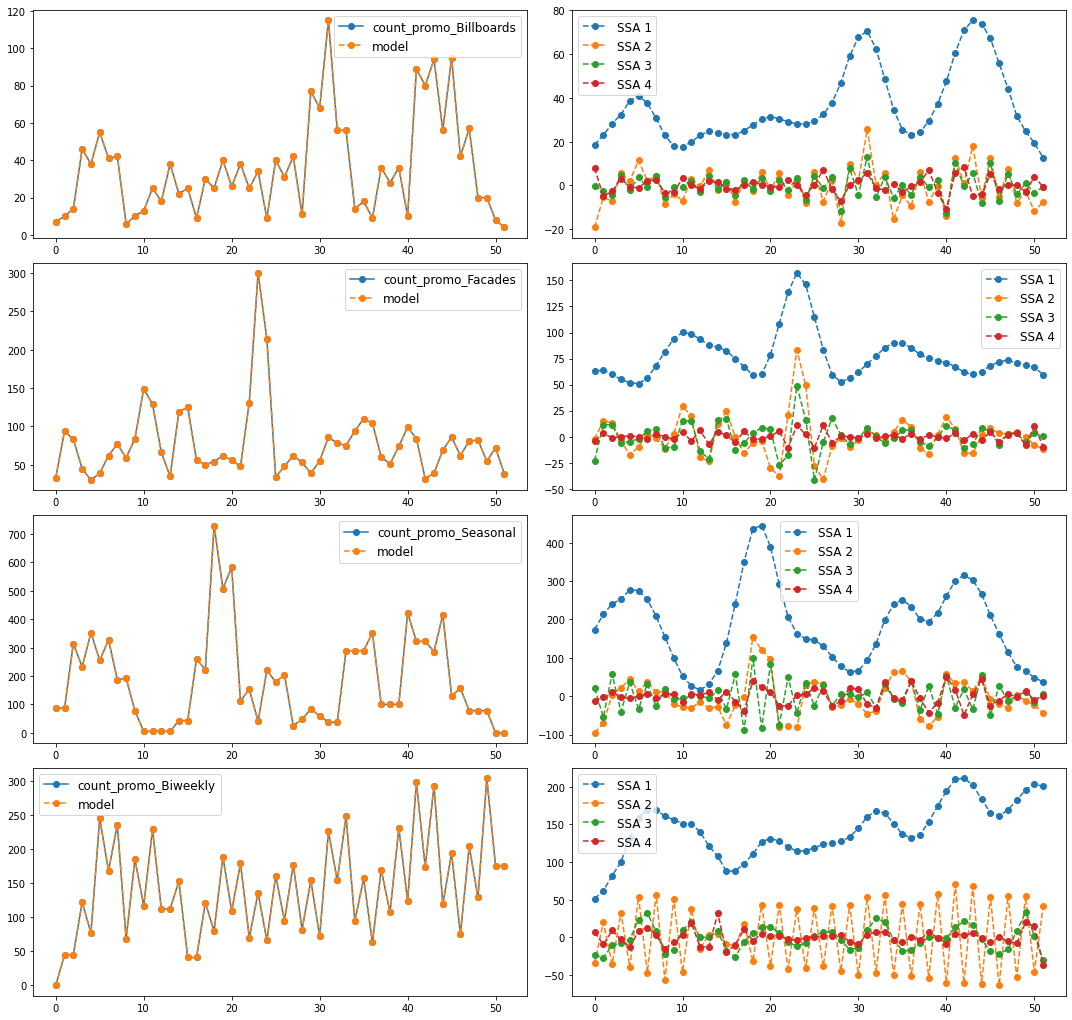

In [ ]:
X_promo = SSA(df_flows[promos])

In [ ]:
# Берем только первые компоненты каждого потока

df_ssa = pd.concat([X_champions, X_loyal, X_sleeping, X_churn, X_promo], axis = 1)
df_ssa.shape

(52, 20)

#### Correlation between series

Let's look at the distribution of values in the series. It's far from normal.

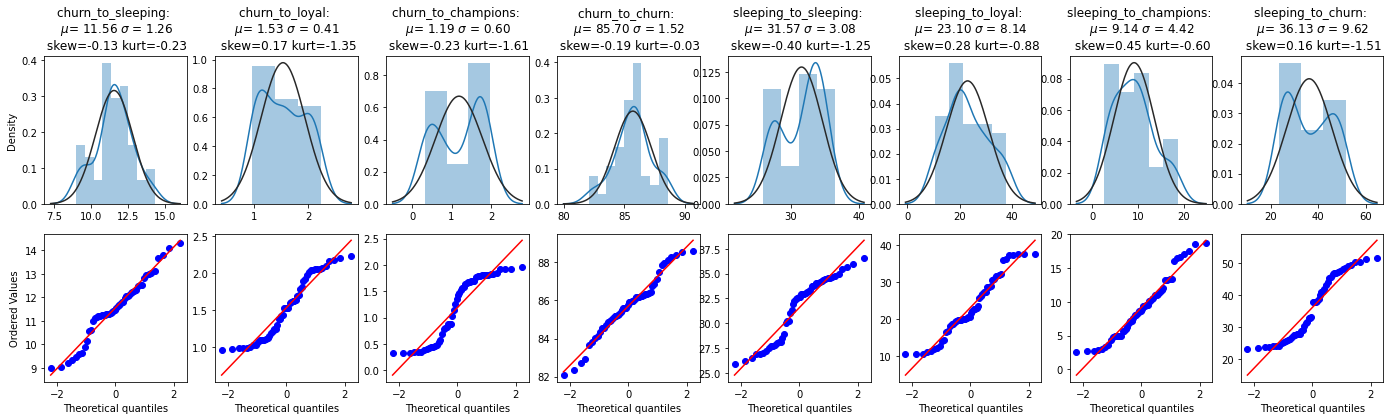

In [ ]:
plot_distr(df_ssa[from_churn + from_loyal].values, from_churn + from_sleeping)

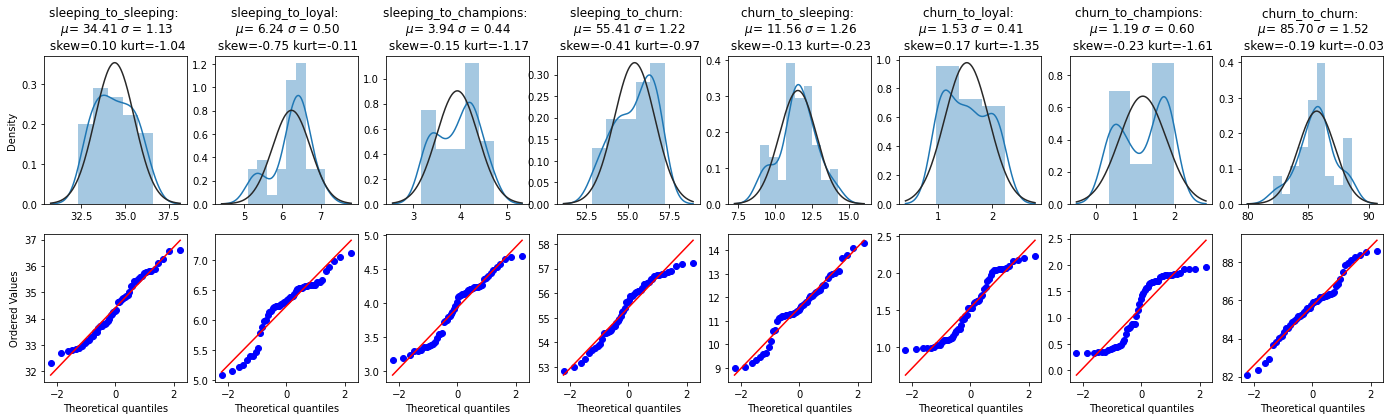

In [ ]:
plot_distr(df_ssa[from_sleeping + from_churn].values, from_sleeping + from_churn)

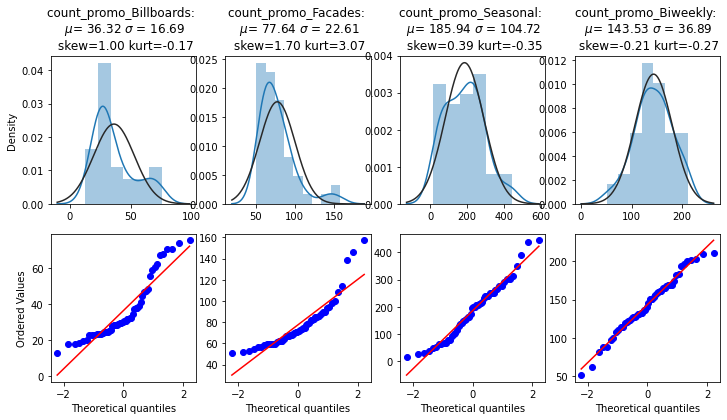

In [ ]:
plot_distr(df_ssa[promos].values, promos)

#### First differences with time-series data

In [ ]:
df_diff = df_ssa.diff(periods = 1, axis = 0)[1:]
df_diff.shape

(51, 20)

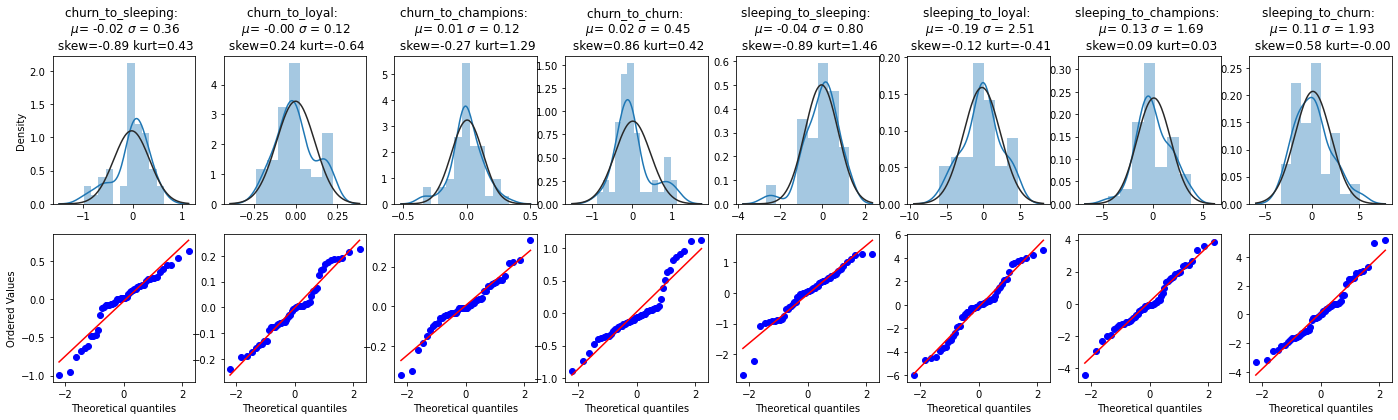

In [ ]:
plot_distr(df_diff[from_churn + from_loyal].values, from_churn + from_sleeping)

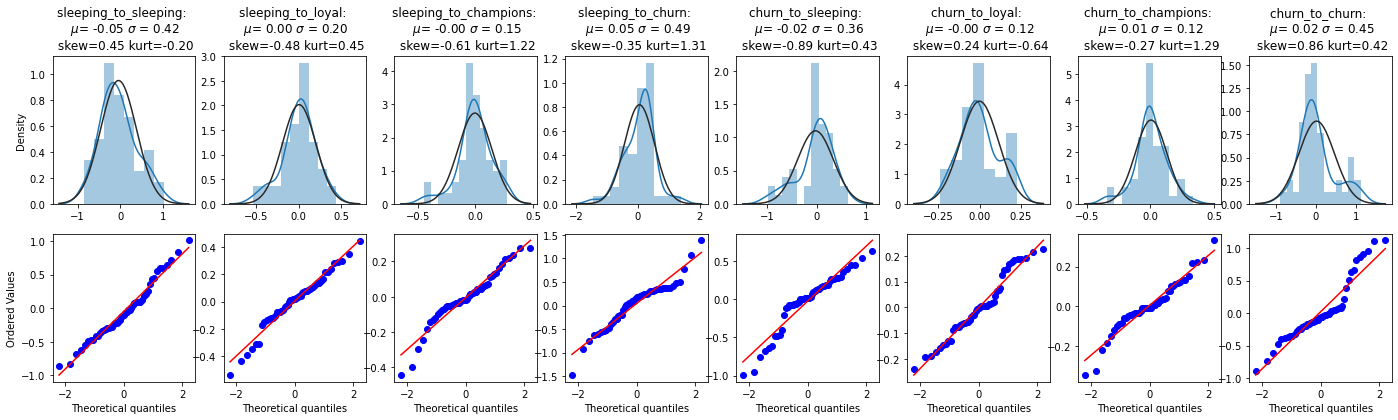

In [ ]:
plot_distr(df_diff[from_sleeping + from_churn].values, from_sleeping + from_churn)

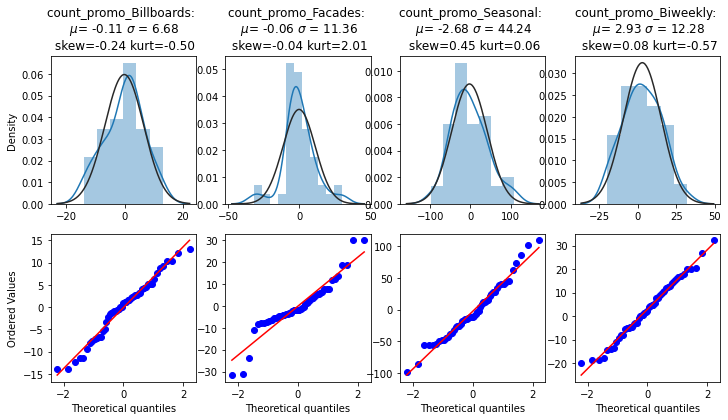

In [ ]:
plot_distr(df_diff[promos].values, promos)

#### Significance of the correlation coefficient $R$:
$$H0: R = 0;  H1: R \neq 0$$
In order to test the hypothesis, we must know the distribution of $R$. The proper distribution of this quantity is quite complex, so we apply the transformation
$$t=\frac{R}{\sqrt{1-R^{2}}}\sqrt{n-2} \sim t_{n-2}$$

That is the sampling distribution of this statistic is the Student distribution with $n-2$ degrees of freedom. For a given significance level $\alpha$, we determine the critical value $t_{cr}$. If $|t| > t_{cr}$, then we reject H0

In [ ]:
# The function calculates the correlation coefficient between series
def significant_correlations(df):
    r = df.corr(method = 'pearson')
    t = r / np.sqrt(1 - r ** 2) * np.sqrt(df.shape[0] - 2)
    t_cr = stats.t.ppf(0.95, df = df_diff.shape[0] - 2)
    mask = (t < -t_cr) | (t > t_cr)
    r  = r[mask]
    return r

lag0 = significant_correlations(df_diff)
# We display only statistically significant values
lag0.loc[promos][flows].style.background_gradient(cmap= 'viridis').highlight_null(null_color = 'white')

,sleeping_to_sleeping,sleeping_to_loyal,sleeping_to_champions,sleeping_to_churn,loyal_to_sleeping,loyal_to_loyal,loyal_to_champions,loyal_to_churn,champions_to_sleeping,champions_to_loyal,champions_to_champions,champions_to_churn,churn_to_sleeping,churn_to_loyal,churn_to_champions,churn_to_churn
count_promo_Billboards,0.275246,-0.314892,nan,nan,nan,nan,nan,nan,nan,nan,0.282512,nan,nan,nan,-0.259560,0.244598
count_promo_Facades,nan,nan,0.481755,nan,nan,0.520981,-0.305897,-0.353466,nan,-0.329462,nan,0.288263,0.596590,nan,0.345652,-0.600609
count_promo_Seasonal,nan,-0.239836,-0.359972,nan,nan,nan,-0.275787,nan,nan,nan,0.303693,nan,-0.315276,nan,-0.323736,0.376355
count_promo_Biweekly,nan,nan,nan,nan,nan,nan,nan,-0.282609,nan,nan,nan,nan,nan,nan,nan,nan


In [ ]:
# Another function for calculating correlation with p-value

from scipy.stats import pearsonr

def sign_corr(df):
    rho = df.corr()
    pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
    return rho.round(2).astype(str) + p

sign_corr(df_diff).loc[promos][flows].style

,sleeping_to_sleeping,sleeping_to_loyal,sleeping_to_champions,sleeping_to_churn,loyal_to_sleeping,loyal_to_loyal,loyal_to_champions,loyal_to_churn,champions_to_sleeping,champions_to_loyal,champions_to_champions,champions_to_churn,churn_to_sleeping,churn_to_loyal,churn_to_champions,churn_to_churn
count_promo_Billboards,0.28*,-0.31**,-0.07,-0.1,0.12,-0.06,0.0,0.05,0.09,-0.14,0.28**,-0.19,-0.21,0.0,-0.26*,0.24*
count_promo_Facades,-0.09,0.13,0.48***,-0.12,-0.11,0.52***,-0.31**,-0.35**,0.03,-0.33**,0.17,0.29**,0.6***,0.05,0.35**,-0.6***
count_promo_Seasonal,0.13,-0.24*,-0.36***,0.1,-0.15,0.22,-0.28*,0.03,0.13,-0.22,0.3**,-0.12,-0.32**,-0.1,-0.32**,0.38***
count_promo_Biweekly,0.13,-0.1,0.14,-0.12,0.23,0.17,-0.01,-0.28**,-0.0,-0.17,0.2,0.02,-0.01,-0.14,0.09,0.03


In [ ]:
# Let's see what the correlation will be if the output (stream) is shifted by 1 week in relation to the treatment (promotion)
significant_correlations(pd.concat([df_diff[promos].shift(periods = 1), df_diff[flows]], axis = 1)).loc[promos][flows].style.background_gradient(cmap= 'viridis').highlight_null(null_color = 'white')

,sleeping_to_sleeping,sleeping_to_loyal,sleeping_to_champions,sleeping_to_churn,loyal_to_sleeping,loyal_to_loyal,loyal_to_champions,loyal_to_churn,champions_to_sleeping,champions_to_loyal,champions_to_champions,champions_to_churn,churn_to_sleeping,churn_to_loyal,churn_to_champions,churn_to_churn
count_promo_Billboards,0.265284,-0.311204,nan,nan,nan,nan,nan,nan,0.236382,-0.257969,0.382881,-0.236969,nan,nan,-0.294947,nan
count_promo_Facades,-0.309717,nan,nan,0.234233,nan,0.421030,-0.316431,nan,nan,-0.416985,nan,0.313089,0.513511,0.294682,nan,-0.515310
count_promo_Seasonal,0.281483,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.240187
count_promo_Biweekly,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [ ]:
# The same thing, but the lag is 2 weeks
significant_correlations(pd.concat([df_diff[promos].shift(periods = 2), df_diff[flows]], axis = 1)).loc[promos][flows].style.background_gradient(cmap= 'viridis').highlight_null(null_color = 'white')

,sleeping_to_sleeping,sleeping_to_loyal,sleeping_to_champions,sleeping_to_churn,loyal_to_sleeping,loyal_to_loyal,loyal_to_champions,loyal_to_churn,champions_to_sleeping,champions_to_loyal,champions_to_champions,champions_to_churn,churn_to_sleeping,churn_to_loyal,churn_to_champions,churn_to_churn
count_promo_Billboards,nan,nan,nan,nan,-0.342788,nan,-0.320040,nan,0.323649,-0.287608,0.397714,-0.260917,nan,nan,-0.293618,nan
count_promo_Facades,-0.384431,nan,-0.365333,0.470228,nan,nan,nan,nan,0.343081,-0.297728,nan,nan,0.302644,0.501359,-0.252485,-0.305653
count_promo_Seasonal,0.326050,nan,nan,-0.238108,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
count_promo_Biweekly,nan,nan,nan,nan,nan,0.263408,-0.263021,nan,nan,nan,nan,nan,nan,nan,nan,nan


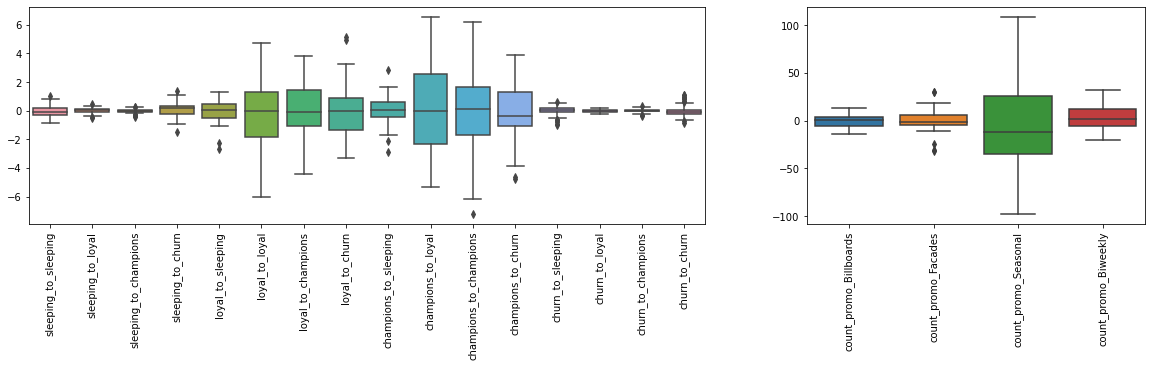

In [ ]:
# Visualization to assess the extent of changes in flows and promotions

fig, ax = plt.subplots(nrows =1, ncols = 2, figsize = (20,4), gridspec_kw={'width_ratios': [2, 1]})
sns.boxplot(data = df_diff[flows], ax = ax[0]);
plt.setp(ax[0].get_xticklabels(), rotation=90);
sns.boxplot(data = df_diff[promos], ax = ax[1]);
plt.setp(ax[1].get_xticklabels(), rotation=90);

In [ ]:
# Dataset for analysis in R
df_diff.to_csv('flow_ssa_diff.csv', index = False)